In [492]:
import numpy as np 
import lmfit as lm 
import pandas as pd 
import os 
import sys 
sys.path.append('C:/Users/Amalya/Research_Local/Analysis_Scripts/')
from General_Functions_ACJ import * 
from Raman_Analysis_Functions import *
from scipy.optimize import curve_fit as curve_fit
from scipy.optimize import root_scalar
from scipy.special import iv, kn, kv, ive, kve
import scipy.integrate as integrate 
from PIL import Image

In [869]:
from IPython.display import display, Latex

In [ ]:
glob.glob('')

In [1113]:
dWdP = pd.read_csv('c:/Users/Amalya/Research_Local/Analysis_Scripts/raman_dwdp.csv', index_col=0)
dWdP_10 = dWdP[dWdP['objective'] == 10]
dWdP_20 = dWdP[dWdP['objective'] == 20]
dWdP_100 = dWdP[dWdP['objective'] == 100]
ctrl_100x = dWdP_100[dWdP_100['wrinkle_spacing'] == 0] #cm-1/mW
ctrl_10x = dWdP_10[dWdP_10['wrinkle_spacing'] == 0] #cm-1/mW
ctrl_20x = dWdP_20[dWdP_20['wrinkle_spacing'] == 0] #cm-1/mW

ctrl_100x =ctrl_100x['dwdP_A1g'][1] * 1e3 * 1/0.05 # estimate 5% absorbed #cm-1/W
ctrl_20x = ctrl_20x['dwdP_A1g'][0] * 1e3 * 1/0.05 # estimate 5% absorbed #cm-1/W
ctrl_10x = ctrl_10x['dwdP_A1g'][0] * 1e3 * 1/0.05 # estimate 5% absorbed #cm-1/W

display(Latex('$\chi_{W,100}$' + f'={ctrl_100x}' ))
display(Latex('$\chi_{W,20}$' + f'={ctrl_20x}' ))
display(Latex('$\chi_{W,10}$' + f'={ctrl_10x}' ))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [901]:
import glob
import h5py as h5
Tdep_raman = glob.glob('G:My Drive/Diffusion_Experiments/*/*raman*Tdep*andor_ccd_readout_montana*')
Tdep_raman.sort()

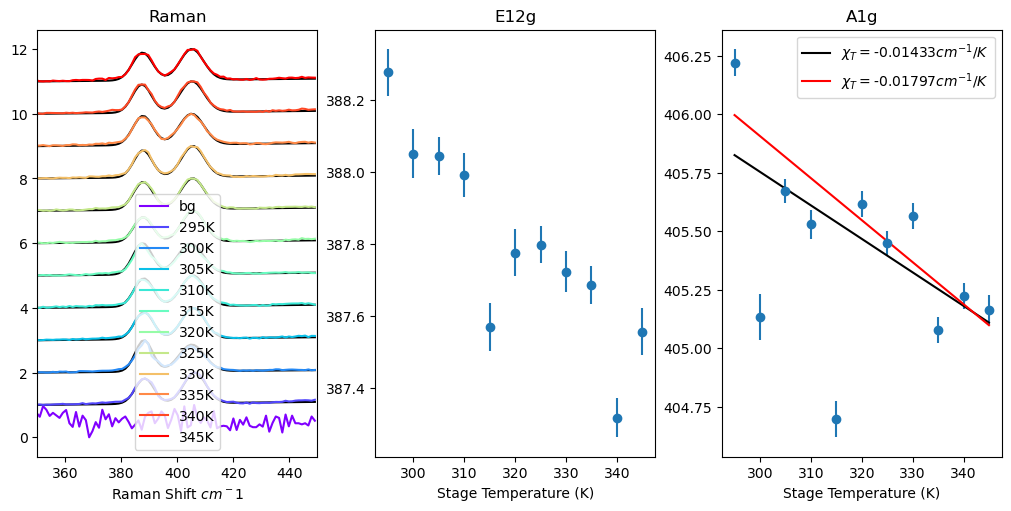

In [973]:
colors = plt.cm.rainbow(np.linspace(0,1,len(Tdep_raman)))
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,5), constrained_layout=True)
A1g_T = []
A1g_T_err = []
E12g_T = []
E12g_T_err = []
T= []
for i, f in enumerate(Tdep_raman): 
    file = h5.File(f)
    temp = f.split('Tdep')[-1].split('_')[1]
    wl = np.array(file['/measurement/andor_ccd_readout_montana/wls'])
    spectrum = np.array(file['/measurement/andor_ccd_readout_montana/spectrum'])[0]
    start, stop = wv_range(wl, 350, 450)
    if 'bg' not in f:
        x = wl[start:stop]
        y = spectrum[start:stop]
        out = custom_function(x, y, 2, GaussianModel, LinearModel, [390,405], peaktol=50)
        peak1 = out.params['g0_center'].value
        peak2 = out.params['g1_center'].value
        peak1_err = out.params['g0_center'].stderr
        peak2_err = out.params['g1_center'].stderr
        E12g_T.append(peak1)
        E12g_T_err.append(peak1_err)
        A1g_T.append(peak2)
        A1g_T_err.append(peak2_err)
        ax1.plot(x, normalize_data(out.best_fit) + i*1, color='k')
        T.append(float(temp.replace('K', '')))
    ax1.plot(wl[start:stop], normalize_data(spectrum[start:stop]) + i *1, color=colors[i], label=temp)
ax1.legend()
ax1.set_xlim(350,450)

A1g_T = np.array(A1g_T)
A1g_T_err = np.array(A1g_T_err)
E12g_T = np.array(E12g_T)
E12g_T_err = np.array(E12g_T_err)

ax2.errorbar(T, E12g_T, E12g_T_err, marker='o', linestyle='')
ax3.errorbar(T, A1g_T, A1g_T_err, marker='o', linestyle='')
popt, pcov = curve_fit(linear, T, A1g_T, sigma=A1g_T_err, absolute_sigma=True)
ax3.plot(T, linear(T, *popt), color='k', label=rf'$\chi_T = $' + str(round(popt[0], 5)) + r'$cm^{-1} / K$')
chi_T_A1g = popt[0]

new_A1g_T = np.delete(A1g_T, [1, 4])
new_T  = np.delete(T, [1,4])
new_A1g_T_err = np.delete(A1g_T_err, [1,4])
popt, pcov = curve_fit(linear, new_T, new_A1g_T, sigma=new_A1g_T_err, absolute_sigma=True)
ax3.plot(new_T, linear(new_T, *popt), color='r', label=rf'$\chi_T = $' + str(round(popt[0], 5)) + r'$cm^{-1} / K$')
chi_T_A1g_edited = popt[0]

ax1.set_title('Raman')
ax2.set_title('E12g')
ax3.set_title('A1g')
ax2.set_xlabel('Stage Temperature (K)')
ax3.set_xlabel('Stage Temperature (K)')
ax1.set_xlabel(rf'Raman Shift $cm^{-1}$')
ax3.legend()

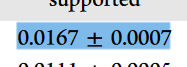

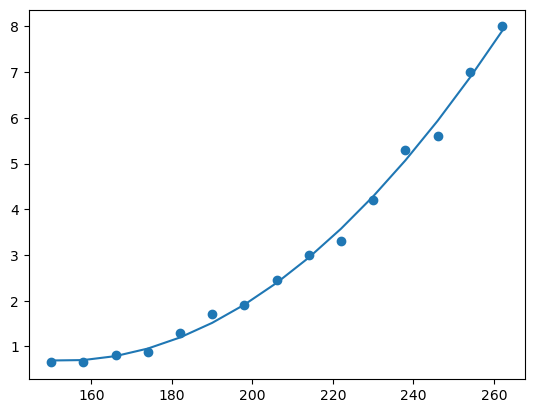

In [1025]:
# Powers 1026
angles = np.arange(150,270,8) #B
power_dict = {'150':0.65, '158':0.66, '166':0.81, '174':0.88, '182':1.3, '190':1.7, '198':1.9, '206':2.45, '214':3, '222':3.3, '230':4.2, '238':5.3, '246':5.6, '254':7, '262':8}
plt.scatter(angles, power_dict.values())
def x2(x, a, b, c):
    return a*x**2 + b*x + c
popt, pcov = curve_fit(x2, angles, list(power_dict.values()))
plt.plot(angles, x2(angles, *popt))

power_dict = {angle:x2(angle, *popt) for angle in np.arange(150,270,4.)}

In [1045]:
# Plot T vs. absorbed Power 
project = 'Nanobubbles'
data_dir = f'G:/My Drive/Raman_Data/{project}/'
samples_10_26 = create_sample_dict(data_dir, '2023_10_26')
samples_10_09 = create_sample_dict(data_dir, '2023_10_09')


In [1046]:
to_use_1026 = ['NW_MoS2_newCTRL_pdepraman_100x_spot1', 'NW_MoS2_newCTRL_pdepraman_100x_spot2', 'NW_MoS2_newCTRL_PL_100x_spot2', 'NW_MoS2_s52_pdepraman_100x_spot1', 'NW_MoS2_s52_PL_100x_spot1', 'NW_MoS2_s52_pdepraman_100x_spot2', 'NW_MoS2_s53_r3_pdepraman_100x_spot1', 'NW_MoS2_s53_r2_pdepraman_100x_spot2', 'NW_MoS2_s25_r1_pdepraman_100x_spot1', 'NW_MoS2_s25_r3_pdepraman_100x_spot2', 'NW_MoS2_s25_r3_PL_100x_spot2', 'NW_MoS2_s1_r5_PL_100x_spot1', 'NW_MoS2_s1_r5_pdepraman_100x_spot1', 'NW_MoS2_s1_r6_PL_100x_spot2', 'NW_MoS2_s4_r1_ramanpdep_100x_spot1', 'NW_MoS2_s4_r2_ramanpdep_100x_spot2']
to_use_1009 = ['NW_MoS2_s23_r4_ramanpdep_sweeptest', 'NW_MoS2_s23_r5_ramanpdep', 'NW_MoS2_s53_r2_ramanpdep', 'NW_MoS2_s53_r3_ramanpdep', 'NW_MoS2_s52_r1_ramanpdep', 'NW_MoS2_s52_r2_ramanpdep', 'NW_MoS2_s25_r1_ramanpdep', 'NW_MoS2_s25_r3_ramanpdep', 'NW_MoS2_s4_r1_ramanpdep', 'NW_MoS2_s4_r2_ramanpdep', 'NW_MoS2_s1_r5_ramanpdep', 'NW_MoS2_s1_r6_ramanpdep']

In [1054]:
file['/measurement/picam_readout'].keys()

<KeysViewHDF5 ['raman_shifts', 'settings', 'spectrum', 'wave_numbers', 'wavelength']>

In [1055]:
fit_dict_1009 = {key:[] for key in to_use_1009}
for key in to_use_1009: 
    for f in samples_10_09[key]: 
        if 'picam_readout' in f: 
            file = h5.File(f)
            # if 's1' in key: 
            pos = dict(file[f'/hardware/power_wheel/settings'].attrs.items())['position']
            pos = find_nearest(angles, pos)
            shifts = np.array(file['/measurement/picam_readout/raman_shifts'])
            spec = np.array(file['/measurement/picam_readout/spectrum'])
            # plt.plot(shifts, spec, label=key)
            start, stop = wv_range(shifts, 350,450)
            x = shifts[start:stop]
            y = spec[start:stop]
            out = custom_function(x, y, 2, LorentzianModel, LinearModel, [390,405], peaktol=50)
            peak1 = out.params['l0_center'].value
            peak2 = out.params['l1_center'].value
            peak1_err = out.params['l0_center'].stderr
            peak2_err = out.params['l1_center'].stderr
            fit_dict[key].append((peak1, peak1_err, peak2, peak2_err, power_dict[pos]))
            # plt.plot(x, out.best_fit, color='k')
            # plt.plot(shifts, spec, label=pos)    

In [1095]:
popt1, pcov1 = curve_fit(linear, power_1, peak2_1)
popt2, pcov2 = curve_fit(linear, power_2, peak2_2)
popt1_E, pcov1_E = curve_fit(linear, power_1, peak1_1)
popt2_E, pcov2_E = curve_fit(linear, power_2, peak1_2)
(popt1[0] + popt2[0])/2 #1009 is 10x

-0.03405690189543293

In [3]:
700e-6

0.0007

Text(0, 0.5, '$T_m$ ($T = \\frac{\\omega - \\omega_0}{\\chi_T}$) [K]')

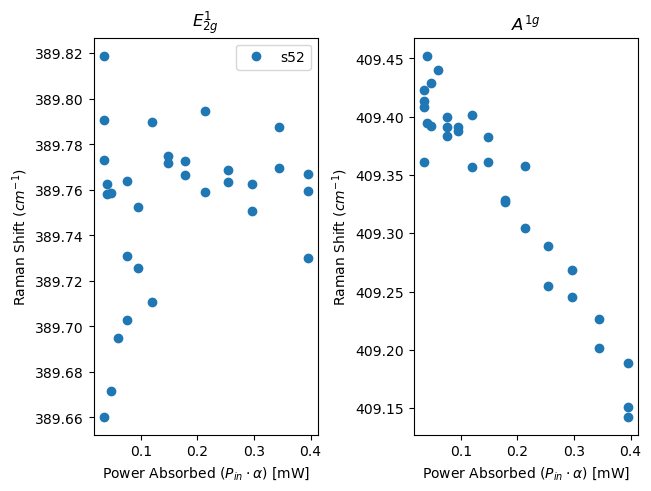

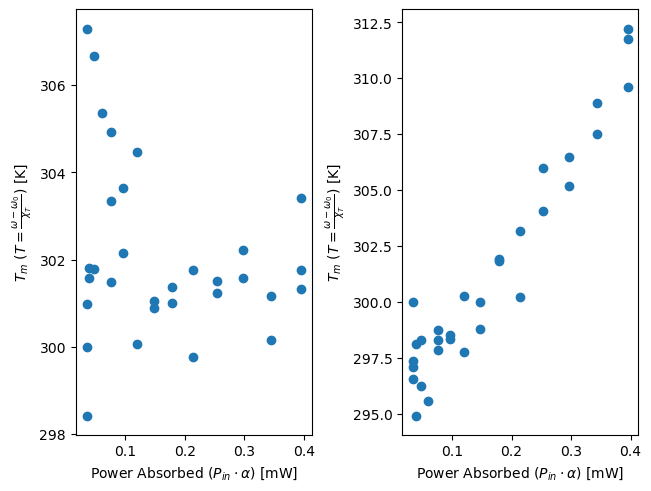

In [1114]:
fig, (ax1, ax2) = plt.subplots(1,2, constrained_layout=True)
fig2, (ax12, ax22) = plt.subplots(1,2, constrained_layout=True)
# for fits in np.array(fit_dict[key]):
lab_dict = {'s53':270, 's23':1500, 's1':440, 's4':580, 's52':0, 'newCTRL':0, 's25':1500}
pairs =[ ['NW_MoS2_s23_r5_ramanpdep',
 'NW_MoS2_s23_r5_ramanpdep'],
 ['NW_MoS2_s53_r2_ramanpdep',
 'NW_MoS2_s53_r3_ramanpdep'],
 [ 'NW_MoS2_s52_r1_ramanpdep',
 'NW_MoS2_s52_r2_ramanpdep'],
 ['NW_MoS2_s25_r1_ramanpdep',
 'NW_MoS2_s25_r3_ramanpdep'],
 [ 'NW_MoS2_s4_r1_ramanpdep',
 'NW_MoS2_s4_r2_ramanpdep'],
 ['NW_MoS2_s1_r5_ramanpdep',
 'NW_MoS2_s1_r6_ramanpdep']]
pairs = [[ 'NW_MoS2_s52_r1_ramanpdep',
 'NW_MoS2_s52_r2_ramanpdep']]

for pair in pairs: 

    sample_name = pair[0].split('NW_MoS2_')[1].split('_')[0]
    fit1 = np.array(fit_dict[pair[0]])
    fit2 = np.array(fit_dict[pair[1]])
    power_1 = fit1[:,4]
    peak2_1 = fit1[:,2]
    peak2_2 = fit2[:,2]
    power_2 = fit2[:,4]

    power_1 = fit1[:,4]
    peak1_1 = fit1[:,0]
    peak1_2 = fit2[:,0]
    power_2 = fit2[:,4]

    peak1_err[peak1_err == None] = 0 
    peak2_err[peak2_err == None] = 0
    power = arr[:,4]
    av_A = (peak1_1 + peak1_2) / 2
    av_E = (peak2_1 + peak2_2) / 2

    # for i, (A, E) in enumerate(zip(av_A, av_E)): 
    #     K = (A * power[i] * 0.05) / -0.179
    w0_A = av_A[0]
    w0_E = av_E[0]

    ax1.plot(power_1*0.05, av_A , marker='o', linestyle='', label=sample_name)
    ax2.plot(power_1*0.05,  av_E, marker='o', linestyle='')

    ax12.plot(power_1*0.05, (av_A - w0_A) / -0.0179 + 300, marker='o', linestyle='', label=sample_name)
    ax22.plot(power_1*0.05, (av_E - w0_E) / -0.0179 + 300, marker='o', linestyle='')

ax1.legend()
ax1.set_title(r'$E^1_{2g}$')
ax2.set_title(r'$A^{1g}$')
# ax1.set_ylim(389,391)
# ax2.set_ylim(406,415)
ax1.set_xlabel(r'Power Absorbed ($P_{in} \cdot \alpha$) [mW]')
ax1.set_ylabel(r'Raman Shift $(cm^{-1})$')
ax2.set_xlabel(r'Power Absorbed ($P_{in} \cdot \alpha$) [mW]')
ax2.set_ylabel(r'Raman Shift $(cm^{-1})$')
ax22.set_xlabel(r'Power Absorbed ($P_{in} \cdot \alpha$) [mW]')
ax12.set_xlabel(r'Power Absorbed ($P_{in} \cdot \alpha$) [mW]')
ax22.set_ylabel(r'$T_m$ ($T = \frac{\omega - \omega_0}{\chi_T}$) [K]')
ax12.set_ylabel(r'$T_m$ ($T = \frac{\omega - \omega_0}{\chi_T}$) [K]')


In [1101]:
av_A * 

array([389.79080689, 389.77330044, 389.6602287 , 389.81896209,
       389.75825664, 389.76244497, 389.75866559, 389.67139526,
       389.69476632, 389.70268135, 389.76397466, 389.73082939,
       389.72558621, 389.75228688, 389.78977769, 389.7106805 ,
       389.77188389, 389.77492222, 389.76641317, 389.7727582 ,
       389.75920201, 389.79486782, 389.76851163, 389.76355935,
       389.76258528, 389.750873  , 389.78780707, 389.76973683,
       389.76692729, 389.75937258, 389.72989764])

(350.0, 450.0)

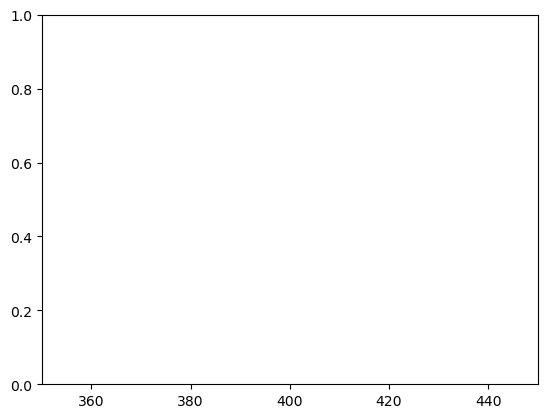

In [1032]:
fit_dict = {key:[] for key in to_use_1026}
for key in to_use_1026: 
    for f in samples_10_26[key]: 
        if 'picam_readout' in f: 
            file = h5.File(f)
            # if 's1' in key: 
            pos = dict(file[f'/hardware/power_wheel/settings'].attrs.items())['position']
            pos = find_nearest(angles, pos)
            shifts = np.array(file['/measurement/picam_readout/raman_shifts'])
            spec = np.array(file['/measurement/picam_readout/spectrum'])
            # plt.plot(shifts, spec, label=key)
            start, stop = wv_range(shifts, 350,450)
            x = shifts[start:stop]
            y = spec[start:stop]
            out = custom_function(x, y, 2, LorentzianModel, LinearModel, [390,405], peaktol=50)
            peak1 = out.params['l0_center'].value
            peak2 = out.params['l1_center'].value
            peak1_err = out.params['l0_center'].stderr
            peak2_err = out.params['l1_center'].stderr
            fit_dict[key].append((peak1, peak1_err, peak2, peak2_err, power_dict[pos]))
            # plt.plot(x, out.best_fit, color='k')
            # plt.plot(shifts, spec, label=pos)    

0 -0.055965394117875926 -0.10356617881311914
0 -0.0882358351304947 -0.2109114263606941
270 -0.07047145516479397 -0.023268592428888516
1500 -0.1065008674430435 -0.06948022257637154
440 -0.6627707894565565 -0.6627707894565565
580 -0.082307160672255 -0.10334039916938963


Text(0.5, 0.98, '100X')

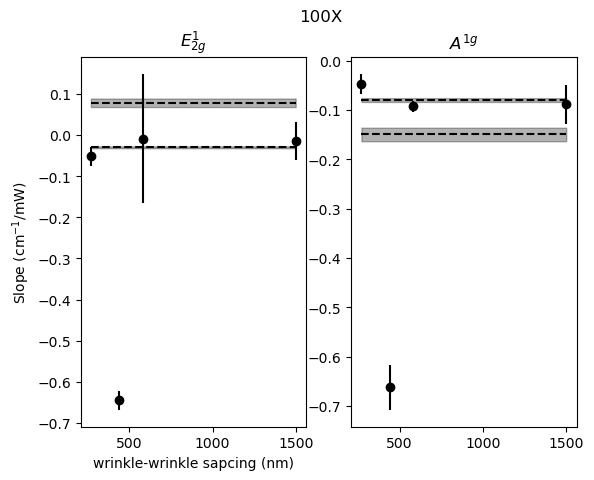

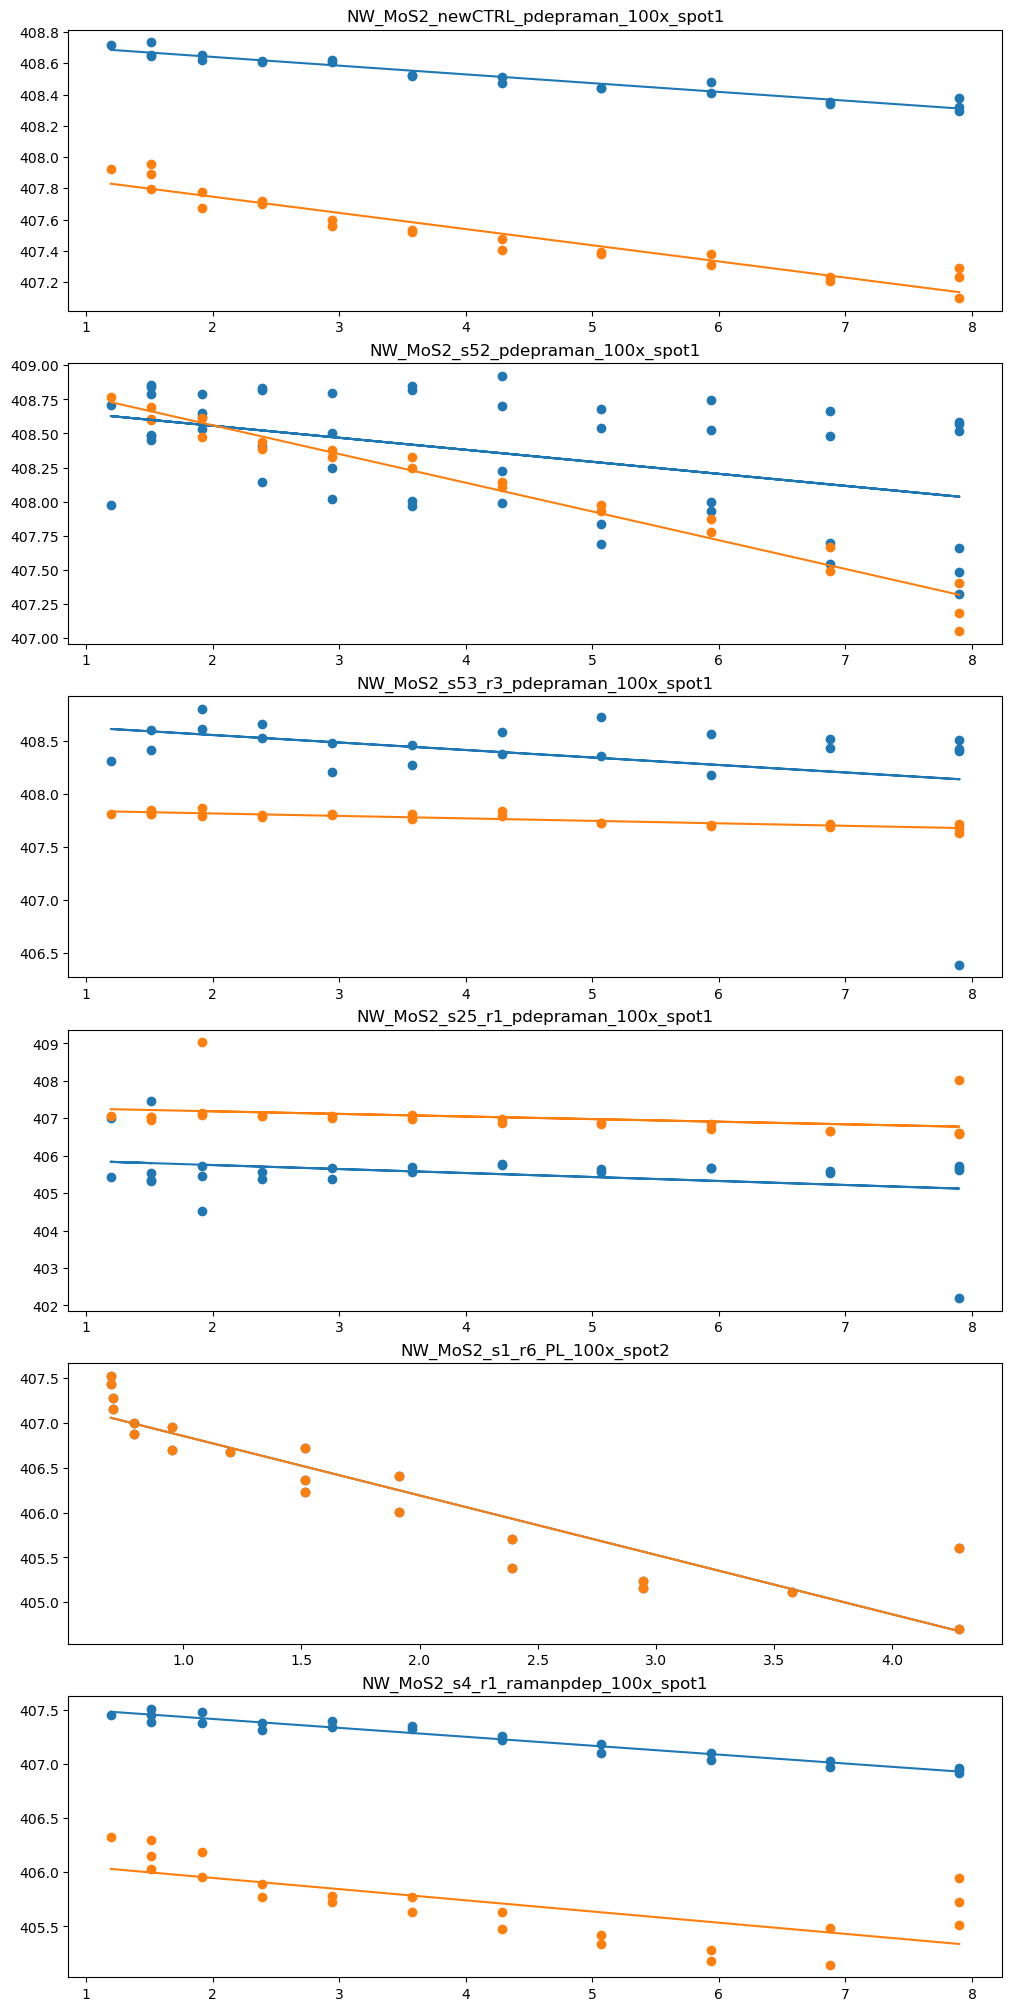

In [1043]:
pairs =[ 
 ['NW_MoS2_newCTRL_pdepraman_100x_spot1',
 'NW_MoS2_newCTRL_pdepraman_100x_spot2'],
 [ 'NW_MoS2_s52_pdepraman_100x_spot1',
 'NW_MoS2_s52_pdepraman_100x_spot2'],
 ['NW_MoS2_s53_r3_pdepraman_100x_spot1',
 'NW_MoS2_s53_r2_pdepraman_100x_spot2'],
 [ 'NW_MoS2_s25_r1_pdepraman_100x_spot1',
 'NW_MoS2_s25_r3_pdepraman_100x_spot2'],
 ['NW_MoS2_s1_r6_PL_100x_spot2',
 'NW_MoS2_s1_r6_PL_100x_spot2'],
 ['NW_MoS2_s4_r1_ramanpdep_100x_spot1',
 'NW_MoS2_s4_r2_ramanpdep_100x_spot2']]

lab_dict = {'s53':270, 's23':1500, 's1':440, 's4':580, 's52':0, 'newCTRL':0, 's25':1500}

# masks = [410,410,410,409,410]
masks = [(400, 420),(407, 410),(405, 410),(400, 420),(400, 420),(400, 420),(400, 420),(400, 420)]
f, (ax1, ax2) = plt.subplots(1,2)
ff, axs = plt.subplots(6,1,figsize=(10,20), constrained_layout=True)
# axs.ravel()
for pair, threshold, ax in zip(pairs, masks, axs): 

    sample_name = pair[0].split('NW_MoS2_')[1].split('_')[0]
    fit1 = np.array(fit_dict[pair[0]])
    fit2 = np.array(fit_dict[pair[1]])
    power_1 = fit1[:,4]
    peak2_1 = fit1[:,2]
    peak2_2 = fit2[:,2]
    power_2 = fit2[:,4]

    power_1 = fit1[:,4]
    peak1_1 = fit1[:,0]
    peak1_2 = fit2[:,0]
    power_2 = fit2[:,4]

    threshold1, threshold2 = threshold
    m12 = peak2_1 < threshold2
    m22 = peak2_2 < threshold2
    m11 = peak2_1 > threshold1
    m21 = peak2_2 > threshold1
    power_1 = power_1[np.logical_and(m11, m12)]
    peak2_1 = peak2_1[np.logical_and(m11, m12)]
    power_2 = power_2[np.logical_and(m21, m22)]
    peak2_2 = peak2_2[np.logical_and(m21, m22)]
    peak1_1 = peak1_1[np.logical_and(m11, m12)]
    peak1_2 = peak1_2[np.logical_and(m21, m22)]

    ax.set_title(pair[0])

    if sample_name == 's1': 
        popt1, pcov1 = curve_fit(linear, power_1[power_1 < 5], peak2_1[power_1 < 5])
        popt2, pcov2 = curve_fit(linear, power_2[power_2 < 5], peak2_2[power_2 < 5])
        popt1_E, pcov1_E = curve_fit(linear, power_1[power_1 < 5], peak1_1[power_1 < 5])
        popt2_E, pcov2_E = curve_fit(linear, power_2[power_2 < 5], peak1_2[power_2 < 5])

        ax.scatter(power_1[power_1 < 5], peak2_1[power_1 < 5], label='spot1')
        ax.scatter(power_2[power_2 < 5], peak2_2[power_2 < 5],label='spot2')
        ax.plot(power_1[power_1 < 5], linear(power_1[power_1 < 5], *popt1))
        ax.plot(power_2[power_2 < 5], linear(power_2[power_2 < 5], *popt2))
    else: 
        popt1, pcov1 = curve_fit(linear, power_1[power_1 > 1], peak2_1[power_1 > 1])
        popt2, pcov2 = curve_fit(linear, power_2[power_2 > 1], peak2_2[power_2 > 1])

        popt1_E, pcov1_E = curve_fit(linear, power_1[power_1 > 1], peak1_1[power_1 > 1])
        popt2_E, pcov2_E = curve_fit(linear, power_2[power_2 > 1], peak1_2[power_2 > 1])

        ax.scatter(power_1[power_1 > 1], peak2_1[power_1 > 1], label='spot1')
        ax.scatter(power_2[power_2 > 1], peak2_2[power_2 > 1],label='spot2')
        ax.plot(power_1[power_1 > 1], linear(power_1[power_1 > 1], *popt1))
        ax.plot(power_2[power_2 > 1], linear(power_2[power_2 > 1], *popt2))
    perr1 = np.sqrt(np.diag(pcov1))
    perr2 = np.sqrt(np.diag(pcov2))
    slope1 = popt1[0]
    err1 = perr1[0]
    slope2 = popt2[0]
    err2 = perr2[0]

    perr1_E = np.sqrt(np.diag(pcov1_E))
    perr2_E = np.sqrt(np.diag(pcov2_E))
    slope1_E = popt1_E[0]
    err1_E = perr1_E[0]
    slope2_E = popt2_E[0]
    err2_E = perr2_E[0]

    label = lab_dict[sample_name]
    print(label, slope1, slope2)
    if sample_name == 's52' or 'CTRL' in sample_name:

        ax2.hlines((slope1 + slope2)/2, 270, 1500, color='k', linestyle='--')
        ax2.fill_between(np.arange(270,1500), (slope1 + slope2)/2 + 0.5*np.sqrt(err1**2 + err2**2), (slope1 + slope2)/2 - 0.5*np.sqrt(err1**2 + err2**2), color='k', alpha=0.3)

        ax1.hlines((slope1_E + slope2_E)/2, 270, 1500, color='k', linestyle='--')
        ax1.fill_between(np.arange(270,1500), (slope1_E + slope2_E)/2 + 0.5*np.sqrt(err1_E**2 + err2_E**2), (slope1_E + slope2_E)/2 - 0.5*np.sqrt(err1_E**2 + err2_E**2), color='k', alpha=0.3)
    else:
        ax2.errorbar(label, (slope1 + slope2)/2, 0.5*np.sqrt(err1**2 + err2**2), marker='o', color='k')
        ax1.errorbar(label, (slope1_E + slope2_E)/2, 0.5*np.sqrt(err1_E**2 + err2_E**2), marker='o', color='k')

ax1.set_ylabel('Slope (cm$^{-1}$/mW)')
ax1.set_xlabel('wrinkle-wrinkle sapcing (nm)')
ax2.set_title('$A^{1g}$')
ax1.set_title('$E^{1}_{2g}$')
f.suptitle('100X')

In [991]:
Rm_ctrl_100x = ctrl_100x  / chi_T_A1g #cm-1/W / (K/cm-1) 
Rm_ctrl_20x = ctrl_20x  / chi_T_A1g #cm-1/W / (K/cm-1)
Rm_ctrl_10x = ctrl_10x / chi_T_A1g #cm-1/W / (K/cm-1)

display(Latex('$R_{M,100}$' + f'={round(Rm_ctrl_100x *1e-5, 5)}' + ' $10^5$ K/W'))
display(Latex('$R_{M,20}$' + f'={round(Rm_ctrl_20x *1e-5, 5)}' + ' $10^5$ K/W'))
display(Latex('$R_{M,10}$' + f'={round(Rm_ctrl_10x *1e-5, 5)}' + ' $10^5$ K/W'))

print('The two experiments done at LBL were 20x and 10x')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The two experiments done at LBL were 20x and 10x


In [992]:
test = solve_ratio()

#MoS2 
test.r1 = 1.23e-6 #m #20x, random value from paper -> use theoretical -> measure experimentally
test.r2 = 2.46e-6 #m #10x, 2 * 20x -> use theoretical -> measure experimentally
test.h = 0.7e-9 #m 
test.Rm1 = Rm_ctrl_20x #K/W
test.Rm2 = Rm_ctrl_10x #K/W
k = 55 #W/mK
g = 0.44e6

In [1003]:
garr = np.arange(0.25, 2, 0.25)*1e6
karr = np.arange(45, 70, 1)

G, K = np.meshgrid(garr, karr)
ratio = G/K
Tm_ratio = np.zeros_like(ratio.ravel())
for i,r in enumerate(ratio.ravel()): 
    test.get_ratio(r)
    Tm_ratio[i] = test.Tm_ratio

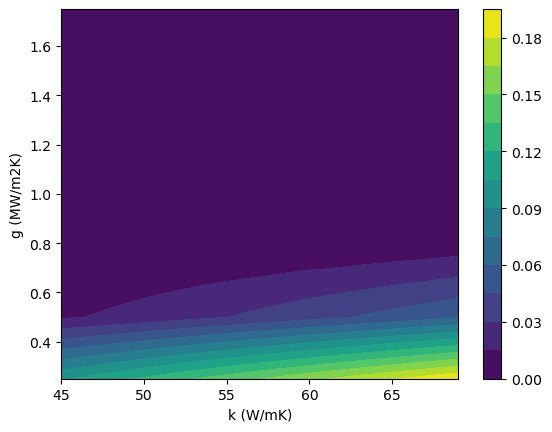

In [1004]:
test.Rm1 / test.Rm2 
Tm_ratio = Tm_ratio.reshape(ratio.shape)
# plt.imshow(Tm_ratio.reshape(K.shape))
plt.contourf(K, G/1e6, Tm_ratio, levels=15)#, cmap=plt.cm.rainbow, vmin=300, vmax=350)
plt.ylabel('g (MW/m2K)')
plt.xlabel('k (W/mK)')
# plt.plot(k, g/1e6, 'r*')
plt.colorbar()

In [1388]:
np.sqrt((0.2/2.0)**2 + (0.02/4.52)**2) * 9

0.9008806092007043

In [1166]:
#MoS2
garr = np.arange(0.2, 1, 0.05)*1e6
karr = np.arange(40, 60, 1)

#Graphene 
# garr = np.arange(20, 40, 1)*1e6
# karr = np.arange(300, 400, 5)
G, K = np.meshgrid(garr, karr)
ratio = G/K
Tm_ratio = np.zeros_like(ratio.ravel())
i = 0
for k in karr:
    for g in garr: 
        # test.get_ratio(r)
        tm1 = integrate.quad(integrand_Tm, 0, 10e-6, args=(qq, k, test.h, test.r1, g))[0] / (test.r1**2 / 2)
        tm2 = integrate.quad(integrand_Tm, 0, 10e-6, args=(qq, k, test.h, test.r2, g))[0] / (test.r2**2 / 2)
        Tm_ratio[i] = tm1/tm2
        i +=1

In [1177]:
Tm_ratio = np.zeros_like(G)
for i in range(G.shape[0]): 
    for j in range(G.shape[1]):
        k = K[i,j]
        g = G[i,j]
        tm1 = integrate.quad(integrand_Tm, 0, 10e-6, args=(qq, k, test.h, test.r1, g))[0] / (test.r1**2 / 2)
        tm2 = integrate.quad(integrand_Tm, 0, 10e-6, args=(qq, k, test.h, test.r2, g))[0] / (test.r2**2 / 2) 
        Tm_ratio[i,j] = tm1/tm2

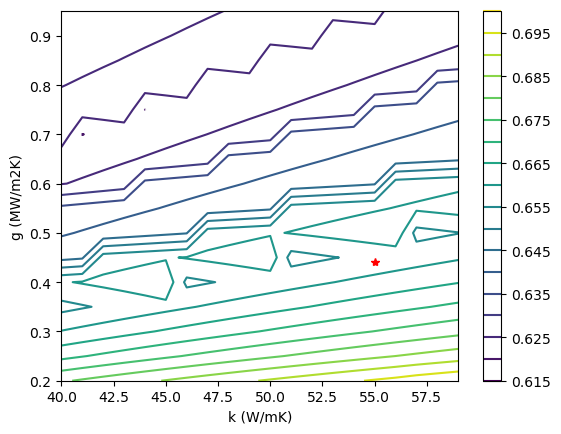

In [1181]:
Tm_ratio = Tm_ratio.reshape(ratio.shape)
# plt.imshow(Tm_ratio.reshape(K.shape))
plt.contour(K, G/1e6, Tm_ratio, levels=15)#, cmap=plt.cm.rainbow, vmin=300, vmax=350)
plt.ylabel('g (MW/m2K)')
plt.xlabel('k (W/mK)')
# plt.plot(370, 28, 'r*')
plt.plot(55, 0.44, 'r*')
plt.colorbar()

Now that was for an anisotropic Beam. Now moving on to anisotropic. \
Source: 
1.  Z. Luo, J. Maassen, Y. Deng, Y. Du, R. P. Garrelts, M. S. Lundstrom, P. D. Ye, X. Xu, Anisotropic in-plane thermal conductivity observed in few-layer black phosphorus. Nature Communications 6, 8572 (2015).

In small-temperature rise regime, Raman mode frequency can be expressed as $$\omega = \omega_o + \chi \theta $$

$\omega_o$ : frequency at room temperature ($cm^{-1}$) \
$\theta$ : temperature rise (K) \
$\chi$ : temperature coefficient ($cm^{-1} / K$) 

To get 1D heat transfer, 75- $\mu$ m-wide rectangular aperture place in front of objective lens to produce a laser focal line instead of a circular spot. Charcterize a gaussian width $w_0$ and length $l_0$ of 0.39 and 3.1 $\mu$ m. Laser is aligned perpendicular to slit flake is suspended over, and the dominant heat flow is perpendicular to the slit. THe absorptivity, reflectivity, and transmissivity are anisotropic -> higher absorption of armchair-polarized light. ... I should think about how my light is polarized w/r/t wrinkles... **I should perform measurments perpendicular and parallel with wrinkles perpendicular and parallel to camera, to see if there is any polarization dependence**.

The heat transport can be described by a three-dimensional anisotropic heat conduction equation

\begin{equation}
\frac{\partial}{\partial x} \left( k_x \frac{\partial \theta}{\partial x}\right) + \frac{\partial}{\partial y} \left( k_y \frac{\partial \theta}{\partial y}\right) + \frac{\partial}{\partial z} \left( k_z \frac{\partial \theta}{\partial z}\right) + \dot q = 0
\tag{7}
\end{equation}

with the heat source term for the stretched laser focal line given as 

\begin{equation}
\dot q = \frac{\alpha (1 - R) P}{\pi w_0 l_0}e^{-(w^2/w_0^2 + l^2/l_0^2)}e^{-\alpha z}
\tag{8}
\end{equation}

$k_x$ : thermal conductivity in x-direction \
$k_y$ : thermal conductivity in y-direction \
$k_z$ : thermal conductivity in z-direction \
$\alpha$ : absorption coefficient 
$w$ : coordinate corresponding to width of focal line 
$l$ : coordinate corresponding to length of focal line 

The temperature rise within the laser focal line is expressed in Gaussian-weighted average form 
\begin{equation}
\theta_{Raman} = \frac{\int_0^t \int_0^\infty \int_0^\infty \theta e^{-(w^2/w_0^2 + l^2/l_0^2 + 2\alpha z)}\mathrm{dw dl dz}}{\int_0^t \int_0^\infty \int_0^\infty e^{-(w^2/w_0^2 + l^2/l_0^2 + 2\alpha z)}\mathrm{dw dl dz}}
\tag{9}
\end{equation}

$t$: film thickness 
Factor 2 comes from absorption of Raman scatern photons within the film when they are travelling back towards the surface

